# Attention Branch Network (ABN)

---

## 目的
ABNの構造を理解する.

ABNを用いてCIFAR-10データセットに対する物体認識を行う．

## Attention Branch Network (ABN)
Attention Branch Network (ABN)[1]とは，Attention機構により推論時における注視領域の可視化と，画像認識の高精度化ができるネットワークです．
02_CAM.ipynbで使用したClass Activation Mapping (CAM)[2] は，CNNが推論時に着目した領域をAttention mapとして可視化できる一方で，最後の畳み込み層の後のGlobal Average Pooling (GAP)[3] によって特徴マップの空間的な情報が失われることによる認識精度の低下が問題となっていました．
ABNでは，ネットワークの判断根拠であるAttention mapを認識処理に用いることで説明性の高いAttention mapの獲得と認識精度の高精度化を実現しました．
ABNは，Feature extractor，Attention branch，Perception branchの3つのモジュールから構成されています．
Feature extractorは，複数の畳み込み層が含まれており，入力から特徴マップを獲得します．
Attention branchは，特徴マップを受け取り，クラス識別及びAttention mapを生成します．
Attention branchにより生成されたAttention mapは，Attention機構によりFeature extractorから得られた特徴マップ全体に対して重み付けします．
この重み付けした特徴マップを用いてPerception branchにより最終的な各クラスにおける確率を出力します．
これにより，画像認識に有効な領域に着目して学習することができます．
学習時は，以下の式よりAttention branchとPerception branchの学習誤差を用いてネットワークを学習します．

$$L_{all}({\bf x}_i) = L_{att}({\bf x}_i) + L_{per}({\bf x}_i)$$

ここで，${\rm x}_i$は$i$番目の入力画像，$L_{att}({\bf x}_i)$はAttention branch の学習誤差，$L_{per}({\bf x}_i)$ はPerception branchの学習誤差を示します．
ABNは，Attention branchをベースラインのネットワークに追加することで，様々な画像認識タスクに応用することができます．

### Attention branch
Attention branchは，畳み込み層とGAPから構成されており，Attention mapを出力するモジュールです．Attention branchでは，GAPの2層前の特徴マップに対し，$1×1$の重みフィルタを畳み込みます．
その後，Sigmoid関数により0から1の範囲に正規化することでAttention mapを獲得します．

### Attention機構
Attention機構とは，認識に有益な特徴量に対して重み付けして学習することで，ネットワークの汎化性能を向上させる方法です．
ABNでは，Attention branchにより生成されたAttention mapをAttention機構によりFeature extractorから得られた特徴マップ全体に対して重み付けします．
また，重み付け後の特徴マップに重み付け前の特徴マップを加算することで，特徴マップの消失を抑制し，Attention mapを認識に効率的に反映させることができます．
ABNでは，以下の式よりFeature extractorから得られた特徴マップに対してAttention mapを重み付けします．

$$f'({\rm x}_i)=(1+M({\rm x}_i))\cdot f({\rm x}_i)$$

ここで，$M({\rm x}_i)$は$i$番目の入力画像に対するAttention mapを示しています．

### Perception branch
Perception branchは，Attention機構により重み付けされた特徴マップを入力し，最終的な認識結果を出力します．
<img src="https://github.com/himidev/Lecture/blob/main/11_cnn_pytorch/05_abn/ABN.png?raw=true" width = 100%>




## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**

## モジュールのインポート
はじめに必要なモジュールをインポートする．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`GPU availability: True`と表示されれば，GPUを使用した計算をPyTorchで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．

In [ ]:
# モジュールのインポート
from time import time
import math
import numpy as np
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import torchsummary

# GPUの確認
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


## 使用するデータセット

### データセット
今回の物体認識では，CIFAR-10データセットを使用します．CIFAR-10データセットは，飛行機や犬などの10クラスの物体が表示されている画像から構成されたデータセットです．

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

## データセットの読み込みとData Augmentation

学習データ（CIFAR10データセット）を読み込みます．
学習には，大量のデータを利用しますが，それでも十分ではありません． そこで，データ拡張 (data augmentation) により，データのバリエーションを増やします． 一般的な方法は，画像の左右反転，明るさ変換などです．

今回はImageNetデータセットで事前に学習したモデルを利用するため，入力サイズをサイズを224ピクセルにします．また，各チャンネルの平均値を基準に平均が0，分散が分散が1になるようにNormalizeを用いて正規化します．

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform_train)
test_data = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



100%|██████████| 170498071/170498071 [00:13<00:00, 12965808.99it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


## ネットワークモデルの定義
### Residual Block (Basic BlockとBottleneck) の定義
まずはじめに，2種類のResidual Block（BasicBlockとBottleneck）を定義します．
ここでは，`BasicBlock(nn.Module)`および`Bottleneck(nn.Module)`で，任意の形の構造（チャンネル数など）を定義できるクラスを作成します．
`__init__`関数の引数である，`inplanes`は入力される特徴マップのチャンネル数，`planes`はBottleNeck内の特徴マップのチャンネル数を指定します．
また，`stride`はResidual Block内の1つ目の3x3の畳み込み層のstrideの値です．
`downsample`は，Residual Blockに入力された特徴マップサイズと畳み込み演算後の特徴マップのサイズが異なる場合に元の特徴マップ (resudual) のサイズを調整するための演算を定義するための引数です（詳細は後述）

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.convs(x)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.expansion * planes),
        )
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.convs(x)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

次に，ABNを定義します．
今回は，ResNetにABNを導入したモデル (ResNet-ABN) を使用します．ResNet-ABNの層の深さ (depth) は，20層に設定します．

In [ ]:
class ResNet_ABN(nn.Module):
    def __init__(self, depth, num_classes=10):
        super(ResNet_ABN, self).__init__()
        # 指定した深さ（畳み込みの層数）でネットワークを構築できるかを確認
        block_name = 'Bottleneck' if depth >=44 else 'BasicBlock'
        if block_name.lower() == 'basicblock':
            assert (depth - 2) % 6 == 0, 'When use basicblock, depth should be 6n+2, e.g. 20, 32, 44'
            n = (depth - 2) // 6
            block = BasicBlock
        elif block_name.lower() == 'bottleneck':
            assert (depth - 2) % 9 == 0, 'When use bottleneck, depth should be 9n+2, e.g. 47, 56, 110, 1199'
            n = (depth - 2) // 9
            block = Bottleneck
        else:
            raise ValueError('block_name shoule be Basicblock or Bottleneck')

        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 16, n, down_size=True)
        self.layer2 = self._make_layer(block, 32, n, stride=2, down_size=True)

        self.att_layer3 = self._make_layer(block, 64, n, stride=1, down_size=False)
        self.bn_att = nn.BatchNorm2d(64 * block.expansion)
        self.att_conv   = nn.Conv2d(64 * block.expansion, num_classes, kernel_size=1, padding=0,
                               bias=False)
        self.bn_att2 = nn.BatchNorm2d(num_classes)
        self.att_conv2  = nn.Conv2d(num_classes, num_classes, kernel_size=1, padding=0,
                               bias=False)
        self.att_conv3  = nn.Conv2d(num_classes, 1, kernel_size=3, padding=1,
                               bias=False)
        self.bn_att3 = nn.BatchNorm2d(1)
        self.att_gap = nn.AvgPool2d(16)
        self.sigmoid = nn.Sigmoid()

        self.layer3 = self._make_layer(block, 64, n, stride=2, down_size=True)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, n_blocks, stride=1, down_size=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        if down_size:
            self.inplanes = planes * block.expansion
            for i in range(0, n_blocks-1):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)
        else:
            inplanes = planes * block.expansion
            for i in range(0, n_blocks-1):
                layers.append(block(inplanes, planes))

            return nn.Sequential(*layers)

    def forward(self, x):
        # feature extractor
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)    # 32x32

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16

        # attention branch
        ax = self.bn_att(self.att_layer3(x))
        ax = self.relu(self.bn_att2(self.att_conv(ax)))
        bs, cs, ys, xs = ax.shape
        self.att = self.sigmoid(self.bn_att3(self.att_conv3(ax)))
        ax = self.att_conv2(ax)
        ax = self.att_gap(ax)
        ax = ax.view(ax.size(0), -1)

        # perception branch
        rx = x * self.att
        rx = rx + x
        rx = self.layer3(rx)  # 8x8
        rx = self.avgpool(rx)
        rx = rx.view(rx.size(0), -1)
        rx = self.fc(rx)

        return ax, rx, self.att



## ネットワークの作成
上のプログラムで定義したネットワークを作成します．
使用したいResdual Block構造の種類に応じて，層数を指定します．

CNNクラスを呼び出して，ネットワークモデルを定義します． 
また，GPUを使う場合（`use_cuda == True`）には，ネットワークモデルをGPUメモリ上に配置します． 
これにより，GPUを用いた演算が可能となります．

学習を行う際の最適化方法としてモーメンタムSGD (モーメンタム付き確率的勾配降下法) を利用します． 
また，学習率を0.01，モーメンタムを0.9として引数に与えます．

最後に，定義したネットワークの詳細情報を`torchsummary.summary()`関数を用いて表示します．

In [ ]:
# ResNetの層数を指定 (e.g. 20, 32, 44, 47, 56, 110, 1199)
depth = 20

# ResNetを構築
model = ResNet_ABN(depth)

if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

## 学習
読み込んだCIFAR-10データセットと作成したネットワークを用いて，学習を行います．
今回は，学習エポック数を10とします．
1エポック学習するごとに学習したモデルを評価し，最も認識精度の高いモデルが保存されます．
各更新において，学習用データと教師データをそれぞれ`image`と`label`とします．
学習モデルに`image`を与えて，Attention branchの出力，Perception branchの出力及びAttention mapを取得します．
Attention branchの出力及びPerception branchの出力と教師ラベル`label`との誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．
認識精度も同時に計算して，`print`関数で学習経過における誤差や認識精度を表示します．

In [ ]:
# ミニバッチサイズ・エポック数の設定
batch_size = 16
epoch_num = 20
n_iter = len(train_data) / batch_size

# データローダーの設定
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

# 誤差関数の設定
criterion = nn.CrossEntropyLoss()
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()

start = time()
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        if use_cuda:
            image = image.cuda()
            label = label.cuda()

        att_outputs, per_outputs, _  = model(image)
        att_loss = criterion(att_outputs, label)
        per_loss = criterion(per_outputs, label)
        loss = att_loss + per_loss

        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(per_outputs, dim=1)
        count += torch.sum(pred == label)

    print("epoch: {}, mean loss: {}, mean accuracy: {}, elapsed_time :{}".format(epoch,
                                                                                 sum_loss / n_iter,
                                                                                 count.item() / len(train_data),
                                                                                 time() - start))
    


epoch: 1, mean loss: 3.332423342552185, mean accuracy: 0.38358, elapsed_time :66.87203884124756
epoch: 2, mean loss: 2.456245816574097, mean accuracy: 0.56628, elapsed_time :134.1792824268341
epoch: 3, mean loss: 2.095084229106903, mean accuracy: 0.64234, elapsed_time :200.8853919506073
epoch: 4, mean loss: 1.8597119724845885, mean accuracy: 0.6853, elapsed_time :268.54656195640564
epoch: 5, mean loss: 1.701566765871048, mean accuracy: 0.71448, elapsed_time :335.6462106704712
epoch: 6, mean loss: 1.5934207626867294, mean accuracy: 0.73416, elapsed_time :402.6094331741333
epoch: 7, mean loss: 1.5024163849449157, mean accuracy: 0.74868, elapsed_time :469.24456334114075
epoch: 8, mean loss: 1.4172737054347992, mean accuracy: 0.76414, elapsed_time :536.1306014060974
epoch: 9, mean loss: 1.3604669436836243, mean accuracy: 0.77738, elapsed_time :603.8102555274963
epoch: 10, mean loss: 1.3188381875228883, mean accuracy: 0.78358, elapsed_time :670.7463297843933
epoch: 11, mean loss: 1.26553986

## テスト
学習したネットワークモデルを用いて評価を行います．

In [ ]:
# データローダーの準備
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:

        if use_cuda:
            image = image.cuda()
            label = label.cuda()
            
        _, outputs, attention = model(image)

        pred = torch.argmax(outputs, dim=1)
        count += torch.sum(pred == label)

print("test accuracy: {}".format(count.item() / len(test_data)))

test accuracy: 0.8556


## Attention mapの可視化
Attention mapを可視化して，ネットワークの判断根拠を確認してみます．
再度，実行することで他のテストサンプルに対するAttention mapを可視化することができます．
predictedは認識結果，conf_dataは認識結果に対する信頼度を示しています．

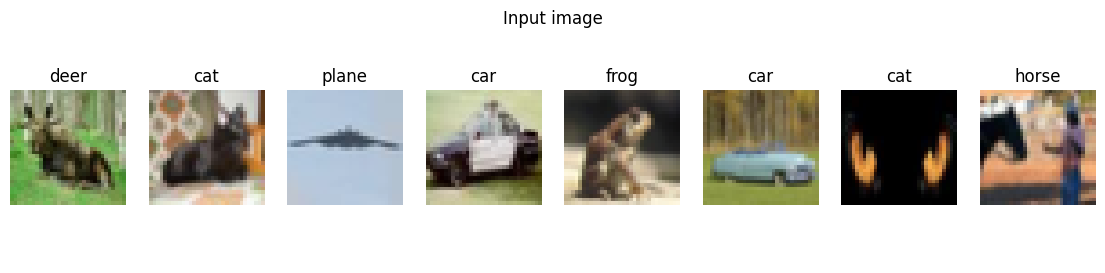

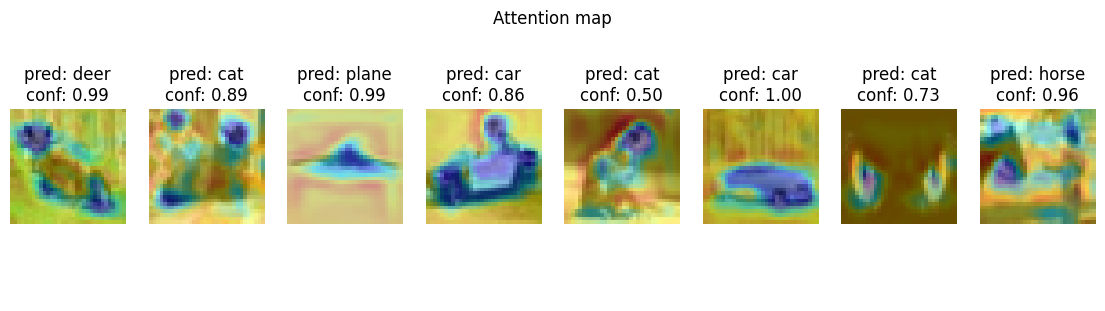

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ipykernel import kernelapp as app


test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, num_workers=2)

classes_list = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

softmax = nn.Softmax(dim=1)

def min_max(x, axis=None):
    x_min = x.min(axis=axis, keepdims=True)
    x_max = x.max(axis=axis, keepdims=True)
    return (x - x_min) / (x_max - x_min)

with torch.no_grad():
    v_list = []
    att_list = []
    for image, label in test_loader:
        if use_cuda:
            image = image.cuda()
            label = label.cuda()
        _, outputs, attention = model(image)
        outputs = softmax(outputs)
        conf_data = outputs.data.topk(k=1, dim=1, largest=True, sorted=True)
        _, predicted = outputs.max(1)
        c_att = attention.data.cpu()
        c_att = c_att.numpy()
        d_inputs = image.data.cpu().numpy()

        in_b, in_c, in_y, in_x = image.shape
        for item_img, item_att in zip(d_inputs, c_att):
            v_img = ((item_img.transpose((1, 2, 0)) * [0.2023, 0.1994, 0.2010]) + [0.4914, 0.4822, 0.4465]) * 255
            #v_img = v_img[:, :, ::-1]
            resize_att = cv2.resize(item_att[0], (in_x, in_y))
            #resize_att = min_max(resize_att)
            resize_att *= 255.

            v_img = np.uint8(v_img)
            resize_att = np.uint8(resize_att)
            jet_map = cv2.applyColorMap(resize_att, cv2.COLORMAP_JET)
            jet_map = cv2.addWeighted(v_img, 0.6, jet_map, 0.4, 0)
            v_list.append(v_img)
            att_list.append(jet_map)
        break

# Show attention map
cols = 8
rows = 1

fig = plt.figure(figsize=(14, 3.0))
plt.title('Input image')
plt.axis("off")
for r in range(rows):
    for c in range(cols):
        cls = label[c].item()
        ax = fig.add_subplot(r+1, cols, c+1)
        plt.title('{}'.format(classes_list[cls]))
        ax.imshow(v_list[cols * r + c])
        ax.set_axis_off()
plt.show()

fig = plt.figure(figsize=(14, 3.5))
plt.title('Attention map')
plt.axis("off")
for r in range(rows):
    for c in range(cols):
        pred = predicted[c].item()
        conf = conf_data[0][c].item()
        ax = fig.add_subplot(r+1, cols, c+1)
        ax.imshow(att_list[cols * r + c])
        plt.title('pred: {}\nconf: {:.2f}'.format(classes_list[pred], conf))
        ax.set_axis_off()
plt.show()

## 課題
1. エポック数やミニバッチサイズを変えて実験し，認識精度とAttention mapの変化を確認しましょう．

In [ ]:
#ここにコードを書く

# 参考文献
- [1] H. Fukui, T. Hirakawa, T. Yamashita, and
H. Fujiyoshi, "Attention branch network: Learning of
attention mechanism for visual explanation". In 2019 IEEE
Conference on Computer Vision and Pattern Recognition,
pp. 10705–10714, 2019.

- [2] B. Zhou, A. Khosla, A. Lapedriza, A. Oliva,
and A. Torralba, "Learning deep features for discriminative
localization". In 2016 IEEE Conference on Computer
Vision and Pattern Recognition, pp. 2921–2929, 2016.

- [3] M. Lin, Q. Chen, and S. Yan, "Network in network".
In 2nd International Conference on Learning Representations,
Banff, AB, Canada, April 14-16, 2014, Conference
Track Proceedings, 2014.